# "Time Series Forecasting"
> "We get the most recent price history data of an item from the Old School RuneScape API, build a transformer encoder, and come up with two ways of separating the data to train the model with (using masked self-attention). We plot predictions vs actual for unseen testing data as well as on the training data to observe any overfitting."

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2a

In [2]:
#hide
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math

We begin by getting the live and historical data via the API

In [266]:
urlTS = 'http://prices.runescape.wiki/api/v1/osrs/timeseries'
headers = {'User-Agent': 'Building GE dataset for data science project'}

timestep = '6h'
id = 24511#12934 # Zulrah's Scales
params = {'id': id, 'timestep': timestep}

responseTS = requests.get(urlTS,headers=headers,params=params)

raw = responseTS.json()
df = pd.DataFrame(raw['data'])
df.head()

,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume
0,1669010400,390599056.0,386834236.0,4,12
1,1669032000,386669137.0,381761366.0,7,12
2,1669053600,380898582.0,373703631.0,14,12
3,1669075200,375158583.0,368797011.0,14,12
4,1669096800,372890000.0,365210263.0,1,6


We then remove any rows with missing datapoints, and interpolate between any rows where the time delta is >6 hours.

In [267]:
#collapse
processed_df = df.copy()
processed_df = processed_df.dropna()
processed_df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')

# there are three times where the time step is not 6 hours, so we interpolate the data the necessary amount of times to make it 6 hours
# this is done by taking the average of the two values and adding it to the dataframe
for i in range(1,len(processed_df['timestamp'])):
    a = processed_df.iloc[i-1]
    b = processed_df.iloc[i]
    delta = (b['timestamp'] - a['timestamp']).total_seconds() / 60 / 60
    if delta != 6.0:
        missingSteps = delta // 6 - 1
        for j in range(int(missingSteps)):
            new_row = a.copy()
            new_row['timestamp'] = a['timestamp'] + pd.Timedelta(hours=6*(j+1))
            for col in processed_df.columns:
                if col != 'timestamp':
                    slope = (b[col] - a[col]) / (missingSteps+1)
                    new_row[col] = a[col] + slope * (j+1)
            processed_df = processed_df.append(new_row, ignore_index=True)

processed_df = processed_df.sort_values(by=['timestamp'])

for a,b in zip(processed_df['timestamp'], processed_df['timestamp'][1:]): # check that there are no more missing time steps
    if (b-a).total_seconds()/60/60 != 6.0:
        print(a,(b-a).total_seconds()/60/60) # there are no more missing time steps

We then create two different dataset classes, one for use with masked self-attention, and that requires no masking.

In [268]:
# create a dataset class for pytorch
context = 32 # number of timesteps to use as context
new_tokens = 16
numFeatures = 4 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use gpu if available

class GEDataOverlap(torch.utils.data.Dataset): # dataset for masked attention with recursive prediction, the y values are shifted by one timestep and are of shape (context, new_tokens, numFeatures)
    def __init__(self, df):
        self.df = df
        self.x = df.drop(['timestamp'],axis=1).values[:,:numFeatures] # drop the timestamp column
        self.x = torch.from_numpy(self.x).float().to(device) # convert to tensor

    def __getitem__(self, idx):
        indexing = torch.arange(idx+1,idx+new_tokens+1).unsqueeze(0)*torch.ones((context,1)) + torch.arange(0,context).unsqueeze(1)*torch.ones((1,new_tokens))
        return self.x[idx:idx+context], self.x[indexing.long()] # return the context and the shifted context as y values
    def __len__(self):
        return len(self.df)-context-new_tokens # subtract the context and new_tokens from the length of the dataset so that we can always get a full context and new_tokens

class GEDataNoOverlap(torch.utils.data.Dataset): # dataset where x and y do not overlap so masking is unnecessary
    def __init__(self, df):
        self.df = df
        self.x = df.drop(['timestamp'],axis=1).values[:,:numFeatures] # drop the timestamp column
        self.x = torch.from_numpy(self.x).float().to(device) # convert to tensor

    def __getitem__(self, idx):
        return self.x[idx:idx+context], self.x[idx+context:idx+context+new_tokens] # return the context and the shifted context as y values
    def __len__(self):
        return len(self.df)-context-new_tokens # return the length of the dataset

# split the data into train and test
train_df = processed_df.iloc[:-(context+new_tokens)]
test_df = processed_df.iloc[-(context+new_tokens):]
train = torch.from_numpy(train_df.values[:,1:][:,:numFeatures].astype('float')).float().to(device) # convert train split to tensor, used for plotting
test = torch.from_numpy(test_df.values[:,1:][:,:numFeatures].astype('float')).float().to(device) 

# create the datasets
train_dataset = GEDataOverlap(train_df)
test_dataset = GEDataOverlap(test_df)

# create the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

I borrow the classes used in OpenAI's CLIP text encoder. It provides an effective framework to build a transformer.

In [7]:
#collapse
class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)

Then I define the model architechture. I use an embedding layer to map the input features to a higher dimensional space, and add a linear layer at the end with the transformer and layer norm squished between.

In [271]:
class GEModel(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.transformer = Transformer(width, layers, heads, attn_mask)
        self.dropout = nn.Dropout(0.3)
        self.head = nn.Linear(width, numFeatures)
        self.position_embedding = nn.Parameter(torch.zeros(context, width))
        self.ln_post = LayerNorm(width)
        self.embed = nn.Linear(numFeatures, width)


    def forward(self, x: torch.Tensor):
        x = self.embed(x)
        x = x + self.position_embedding
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        #x = self.dropout(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_post(x)
        x = self.head(x)
        return x

# atnn_mask = torch.full((context,context),True)
# attn_mask = torch.tril(atnn_mask)
mask = (torch.triu(torch.ones(context, context)) == 1).transpose(0, 1)
mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
model = GEModel(numFeatures*64, 6, 8, attn_mask=mask)
model = model.to(device)

In [273]:
optim = torch.optim.AdamW(model.parameters(), lr=3e-5)
lossfcn = nn.MSELoss()

To help the model learn to predict new timesteps recursively while avoiding long train times, I create a probability distribution that a bernoulli trial samples from. This makes it so that at the beginning of training, predictions are unlikely to be concatenated to the input, but after a few epochs, the model's predictions can be trusted to be concatenated and used to make new predictions.

In [151]:
k = 35 # temperature for probability distribution
max_num_epochs = 1000
# create tensor with shape (max_num_epochs, new_tokens) where each row is a probability distribution for the given epoch
for i in range(max_num_epochs):
    i = i
    v = k/1.5/(k+math.exp(i/k))
    v = torch.tensor(v).repeat(new_tokens)
    v = v.unsqueeze(0)
    if i==0:
        prob = v
    else:
        prob = torch.cat((prob, v), dim=0)
# create bernoulli trial for each epoch
coinFlip = torch.bernoulli(prob)
# check if the row sums to new_tokens and if it does, set the last element to 0
for i in range(max_num_epochs): # required so that each training example has at least one prediction made
    if coinFlip[i].sum() == new_tokens:
        coinFlip[i,-1] = 0

Training Loop for Overlapped Labels

In [274]:
num_epochs = 600
train_losses = np.zeros((num_epochs))
for epoch in range(num_epochs):
    epoch = epoch+300
    batch_losses = []
    model.train()
    for x,y in train_loader:
        B, T, C = x.shape # (batch_size, context, numFeatures)
        for j in range(new_tokens):
            x = x[:,-context:]
            normalized_x = (x-x.mean(1,keepdim=True))/x.std(1,keepdim=True)
            y_pred = model(normalized_x) # (batch_size context, numFeatures), the outputs of the model are shifted forward 1 timestep
            prob_true_val = coinFlip[epoch,j].item() # get the probability of using true value
            if prob_true_val:
                x = torch.cat((x,y[:,-1,j:j+1,:]),dim=1) # add the true value to the input
            else:
                denormalized_y_pred = y_pred[:,-1:,:]*x.std(1,keepdim=True)+x.mean(1,keepdim=True) # denormalize the last timestep prediction
                x = torch.cat((x,denormalized_y_pred),dim=1) # add the prediction to the input     
            if j==0:
                preds = y_pred.unsqueeze(2)
            else:
                preds = torch.cat((preds, y_pred.unsqueeze(2)), dim=2)  
        #normalized_y = (y-x.mean(1,keepdim=True).unsqueeze(2))/x.std(1,keepdim=True).unsqueeze(2)
        normalized_y = (y-y.mean((1,2),keepdim=True))/y.std((1,2),keepdim=True)
        preds = preds.contiguous().view(B*context*new_tokens*C)
        normalized_y = normalized_y.contiguous().view(B*context*new_tokens*C)
        loss = lossfcn(preds, normalized_y)
        loss.backward()
        optim.step()
        optim.zero_grad()
        batch_losses.append(loss.detach().cpu().item())
    train_losses[epoch-300] = np.mean(batch_losses)
    print(f'Epoch {epoch+1-300}/{num_epochs} Train Loss: {np.mean(batch_losses):.4f}')

Epoch 1/600 Train Loss: 1.0369
Epoch 2/600 Train Loss: 0.9025
Epoch 3/600 Train Loss: 0.8592
Epoch 4/600 Train Loss: 0.8141
Epoch 5/600 Train Loss: 0.7480
Epoch 6/600 Train Loss: 0.8076
Epoch 7/600 Train Loss: 0.7727
Epoch 8/600 Train Loss: 0.7792
Epoch 9/600 Train Loss: 0.7716
Epoch 10/600 Train Loss: 0.7709
Epoch 11/600 Train Loss: 0.7578
Epoch 12/600 Train Loss: 0.7604
Epoch 13/600 Train Loss: 0.7421
Epoch 14/600 Train Loss: 0.7481
Epoch 15/600 Train Loss: 0.7280
Epoch 16/600 Train Loss: 0.7365
Epoch 17/600 Train Loss: 0.7120
Epoch 18/600 Train Loss: 0.7204
Epoch 19/600 Train Loss: 0.6943
Epoch 20/600 Train Loss: 0.7175
Epoch 21/600 Train Loss: 0.6844
Epoch 22/600 Train Loss: 0.7902
Epoch 23/600 Train Loss: 0.7212
Epoch 24/600 Train Loss: 0.7057
Epoch 25/600 Train Loss: 0.6862
Epoch 26/600 Train Loss: 0.6593
Epoch 27/600 Train Loss: 0.6554
Epoch 28/600 Train Loss: 0.6586
Epoch 29/600 Train Loss: 0.6554
Epoch 30/600 Train Loss: 0.7095
Epoch 31/600 Train Loss: 0.6656
Epoch 32/600 Trai

Training Loop for No Overlap Labels

In [ ]:
#collapse
num_epochs = 600
train_losses = np.zeros((num_epochs))
for epoch in range(num_epochs):
    epoch = epoch + 300
    batch_losses = []
    model.train()
    for x,y in train_loader:
        B, T, C = x.shape # (batch_size, context, numFeatures)
        for j in range(new_tokens):
            x = x[:,-context:]
            normalized_x = (x-x.mean(1,keepdim=True))/x.std(1,keepdim=True)
            y_pred = model(normalized_x)[:,-1:,:] # get the last prediction
            prob_true_val = coinFlip[epoch,j].item() # get the probability of using true value
            if prob_true_val:
                x = torch.cat((x,y[:,j:j+1,:]),dim=1) # add the true value to the input
            else:
                denormalized_y_pred = y_pred*x.std(1,keepdim=True)+x.mean(1,keepdim=True) # denormalize the prediction
                x = torch.cat((x,denormalized_y_pred),dim=1) # add the prediction to the input     
            if j==0:
                preds = y_pred
            else:
                preds = torch.cat((preds, y_pred), dim=1)  

        normalized_y = (y-x.mean(1,keepdim=True))/x.std(1,keepdim=True)
        preds = preds.contiguous().view(B*new_tokens*C)
        normalized_y = normalized_y.contiguous().view(B*new_tokens*C)
        loss = lossfcn(preds, normalized_y) # loss between the last context predictions and the ground truth
        loss.backward()
        optim.step()
        optim.zero_grad()
        batch_losses.append(loss.detach().cpu().item())
    train_losses[epoch-300] = np.mean(batch_losses)
    print(f'Epoch {epoch+1}/{num_epochs} Train Loss: {np.mean(batch_losses):.4f}')

Plot Training Loss vs Epochs

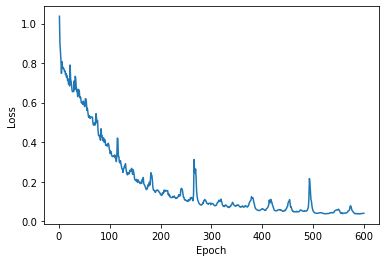

In [275]:
#hide_input
plt.plot(np.arange(1,num_epochs+1),train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Predictions on Test Dataset:

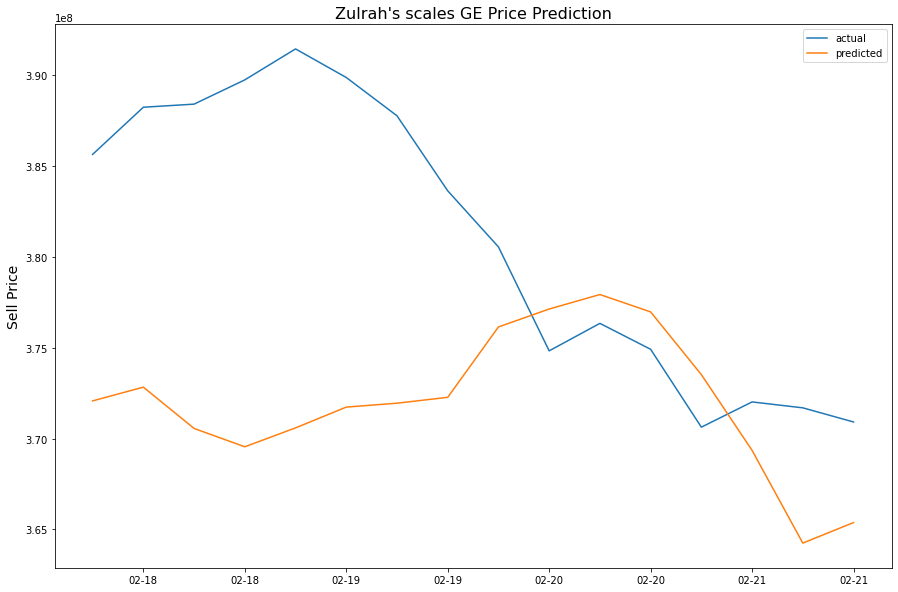

In [276]:
#collapse
num_predictions = new_tokens
predictedValues = test[:context].unsqueeze(0) # start with the first context values

model.eval()
with torch.no_grad():
    for i in range(num_predictions):
        x = predictedValues[:,-context:] # get the last context values, shape (1, context, numFeatures)
        normalized_x = (x-x.mean(1,keepdim=True))/x.std(1,keepdim=True) # normalize the input, not using layernorm b/c we want to scale the input to the same range as the labels, and we do not have access to labels at inference time
        y_pred = model(normalized_x)[:,-1:,:] # get the last prediction
        y_pred = y_pred*x.std(1,keepdim=True)+x.mean(1,keepdim=True) # unnormalize the prediction
        predictedValues = torch.cat((predictedValues, y_pred), dim=1) # add the prediction to the predicted values

myFmt = mdates.DateFormatter('%m-%d')
fig, ax = plt.subplots(figsize=(15,10))
ax.xaxis.set_major_formatter(myFmt)
plt.plot(test_df['timestamp'][context:context+num_predictions], test_df['avgHighPrice'][context:context+num_predictions], label='actual')
plt.plot(test_df['timestamp'][context:context+num_predictions], predictedValues[0,context:context+num_predictions,0].cpu().numpy(), label='predicted')
plt.title('Zulrah\'s scales GE Price Prediction', fontsize=16)
ax.set_ylabel('Sell Price', fontsize=14)
plt.legend()
plt.show()

Predictions on Training Dataset:
Vertical lines show splits between context windows and predictions, meaning that the predictions made between each red line is based on data between the previous red lines

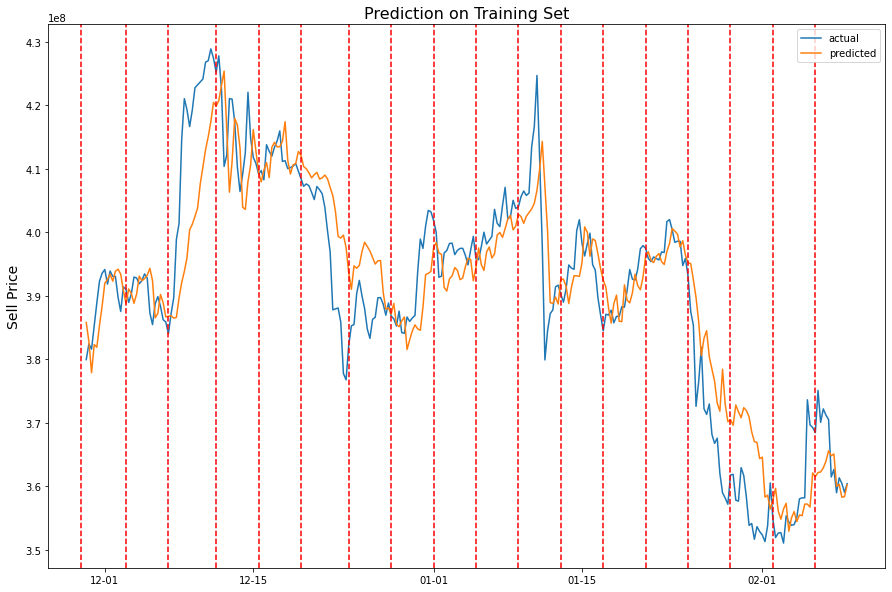

In [277]:
#collapse
numContextWindows = (len(train)-context) // new_tokens
num_predictions = numContextWindows*new_tokens

model.eval()
with torch.no_grad():
    for i in range(numContextWindows):
        x = train[i*(new_tokens):i*(new_tokens)+context].unsqueeze(0) # get the last context values
        for j in range(new_tokens):
            x = x[:,-context:]
            normalized_x = (x-x.mean(1))/x.std(1)
            y_pred = model(normalized_x)[:,-1:,:] # get the last prediction
            y_pred = y_pred*x.std(1)+x.mean(1) # unnormalize the prediction
            x = torch.cat((x,y_pred),dim=1) # add the prediction to the input
            if i==0 and j==0:
                preds = y_pred
            else:
                preds = torch.cat((preds, y_pred), dim=1)          

myFmt = mdates.DateFormatter('%m-%d')
fig, ax = plt.subplots(figsize=(15,10))
ax.xaxis.set_major_formatter(myFmt)
plt.plot(train_df['timestamp'][context:context+num_predictions], train_df['avgHighPrice'][-num_predictions:], label='actual')
plt.plot(train_df['timestamp'][context:context+num_predictions], preds[0,-num_predictions:,0].cpu().numpy(), label='predicted')
# draw a vertical line every new_tokens
for i in range(numContextWindows):
    plt.axvline(x=train_df['timestamp'][context+i*new_tokens-5], color='r', linestyle='--')
plt.title('Prediction on Training Set', fontsize=16)
ax.set_ylabel('Sell Price', fontsize=14)
plt.legend()
plt.show()

In [278]:
# save the model
torch.save(model.state_dict(), 'OverlapModelHarmOrb.pt')